In [31]:
import  pandas as pd
import numpy as np
import re

#Visiualization package
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#language Processing package
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import RegexpTokenizer
import tokenize
from nltk.stem.snowball import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

#feature extraction package
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#ML algorithm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
import itertools

def prepare_data(file_dir):
    df = pd.read_csv(file_dir)

    #drop rows contain null value in lyrics and genre
    df = df.dropna(subset=['lyrics'])
    df = df[df.lyrics != ""]
    df = df[df.genre != ""]

    # decoding
    df.genre.str.decode('utf-8')
    df.lyrics.str.decode('utf-8')

    # strip excessive blank and convert all the string to lower type
    df.lyrics = df.lyrics.str.strip().str.lower()
    df.genre = df.genre.str.strip().str.lower()

    # get rid of \n,-,none char string
    df.lyrics.replace("\n", " ", regex=True, inplace=True)
    df.lyrics.replace("-", " ", regex=True, inplace=True)
    df.lyrics.replace("[^a-zA-Z0-9_\ ]", "", regex=True, inplace=True)
    df.lyrics.replace('"', "", regex=True, inplace=True)

    df.genre.replace("\n", " ", regex=True, inplace=True)
    df.genre.replace("-", " ", regex=True, inplace=True)
    df.genre.replace("[^a-zA-Z0-9_\ ]", "", regex=True, inplace=True)
    df.genre.replace('"', "", regex=True, inplace=True)

    return df

def data_summary(df):
    genre_list=list(set(df.genre))
    year_list=list(set(df.year))

    return genre_list,year_list,df.shape


# drop row if the year is before 2008
def select_year(df,begin,end):
    df = df[:][(df["year"] > begin) & (df["year"] <= end)]
    gen = ['rock', 'hip hop', 'metal', 'country']
    df = df.filter(items=['genre', 'lyrics'], axis=1)
    df = df[df.genre.isin(gen)]

    return df


#functions for visualization
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    print('Confusion matrix, without normalization')
    print(cm)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
def df_to_array(df):
    # Compose the corpus
    Xr = np.array(df.lyrics.loc[df['genre'] == 'rock'])
    Xh = np.array(df.lyrics.loc[df['genre'] == 'hip hop'])
    Xm = np.array(df.lyrics.loc[df['genre'] == 'metal'])
    Xc = np.array(df.lyrics.loc[df['genre'] == 'country'])

    Xw = np.concatenate((Xr, Xh, Xm, Xc))


    # Create the label vectors
    Yr = np.zeros(shape=Xr.shape)
    Yh = np.ones(shape=Xh.shape)
    Ym = np.full(Xm.shape, 2)
    Yc = np.full(Xc.shape, 3)

    Y = np.concatenate((Yr, Yh, Ym, Yc))

    print(len(Xw))
    print(len(Y))

    return Xr,Xh,Xm,Xc,Xw,Y


#word tokenizer
def tokenizer(sentence):
    np.random.seed(1000)
    ret = RegexpTokenizer('[a-zA-Z0-9\']+')
    sw = set(stopwords.words('english')+['get','go','dont','im','know','like','love','go','say','oh','time','come'])
    ess = SnowballStemmer('english', ignore_stopwords=True)
    tokens = ret.tokenize(sentence)
    tokens =[WordNetLemmatizer().lemmatize(t,'v') for t in tokens]

    return [ess.stem(t) for t in tokens if t not in sw]

def vectorizer(array):
    tfidfv = TfidfVectorizer(tokenizer=tokenizer, ngram_range=(1, 2), norm='l2', stop_words='english', min_df=0.01)
    Xv = tfidfv.fit_transform(array)

    return Xv,tfidfv

def term_rank(Xv,tfidfv):
    terms = tfidfv.get_feature_names()

    # sum tfidf frequency of each term through documents
    sums = Xv.sum(axis=0)

    # connecting term to its sums frequency
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col] ))

    ranking = pd.DataFrame(data, columns=['term','rank'])
    ranking=ranking.sort_values('rank',ascending=False)
    term=ranking.iloc[0:10,:]
    plt.barh(term['term'], term['rank'],orientation='horizontal')
    plt.yticks(term['term'].sort_index())
    plt.show()
    

def split_train_test(Xv,Y):
    X_train, X_test, Y_train, Y_test = train_test_split(Xv, Y, test_size=0.2)
    return X_train, X_test, Y_train, Y_test


# Create a Random Forest classifier
def rf_model(X_train, X_test, Y_train, Y_test,gen):
    rf = RandomForestClassifier(n_estimators=100, oob_score=True, verbose=1, max_features="auto", n_jobs=-1)

    rf.fit(X_train, Y_train)

    y_pred = rf.fit(X_train, Y_train).predict(X_test)
    score = rf.score(X_test, Y_test)
    cnf_matrix = confusion_matrix(Y_test, y_pred)
    #gen is the list of genre
    plot_confusion_matrix(cnf_matrix, gen, normalize=True, title='Random Forest')

    return score,plot_confusion_matrix

def ada_model(X_train, X_test, Y_train, Y_test,gen):
    # Create a Adaboost classifier
    param_grid = {'n_estimators': list(range(1,100))}
    ad = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=100,learning_rate=0.1)
    grid_ada = GridSearchCV(ad, param_grid, cv=10,verbose=10)
    grid_ada.fit(X_train, Y_train)

    print(grid_ada.best_estimator_)
    y_pred = grid_ada.fit(X_train, Y_train).predict(X_test)
    score = grid_ada.score(X_test, Y_test)
    cnf_matrix = confusion_matrix(Y_test, y_pred)
    plot_confusion_matrix(cnf_matrix,gen,normalize=True,title='AdaBoost')

    return score,plot_confusion_matrix




# Create a XGBoost Classifier
def xgb_model(X_train, X_test, Y_train, Y_test,gen):
    tuned_parameters = {'learning_rate': [0.4, 0.5],
                        'max_depth': [6, 7]
                        }
    fit_params = {
        "eval_set": [(X_test, Y_test)],
        "eval_metric": 'Accuracy',
        "early_stopping_rounds": 100,
        "verbose": True
    }
    xgb = XGBClassifier(learning_rate=0.1,
                        n_estimators=1000,
                        max_depth=5,
                        min_child_weight=1,
                        gamma=0,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        scale_pos_weight=1,
                        objective='multi:softprob',
                        seed=27)
    grid_xgb = GridSearchCV(xgb, tuned_parameters, verbose=999999,
                              fit_params=fit_params
                              )
    grid_xgb.fit(X_train, Y_train)

    score = grid_xgb.score(X_test, Y_test)
    y_pred = grid_xgb.fit(X_train, Y_train).predict(X_test)
    cnf_matrix = confusion_matrix(Y_test, y_pred)
    plot_confusion_matrix(cnf_matrix,gen,normalize=True,title='AdaBoost')

    return score,plot_confusion_matrix


# Create a LogisticRegression classifier
def log_model(X_train, X_test, Y_train, Y_test,gen):
    param_grid = [{'penalty': ['l1', 'l2'], 'C': [0.5, 1.0, 1.5, 1.8, 2.0, 2.5]}]
    lg=LogisticRegression(C=1,multi_class='multinomial',solver='newton-cg')
    gs = GridSearchCV(estimator=lg, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
    gs.fit(X_train, Y_train)
    y_pred = gs.fit(X_train, Y_train).predict(X_test)
    score = gs.score(X_test, Y_test)
    cnf_matrix = confusion_matrix(Y_test, y_pred)
    plot_confusion_matrix(cnf_matrix,gen,normalize=True,title='AdaBoost')

    return score,plot_confusion_matrix



#Create Naive Bayes Classifier
def nb_model(X_train, X_test, Y_train, Y_test,gen):
    number = 1 / 548272
    model = MultinomialNB(alpha=number)
    model.fit(X_train, Y_train)
    y_pred = model.fit(X_train, Y_train).predict(X_test)
    score = model.score(X_test, Y_test)
    cnf_matrix = confusion_matrix(Y_test, y_pred)
    plot_confusion_matrix(cnf_matrix,gen,normalize=True,title='AdaBoost')

    return score,plot_confusion_matrix


# visualization => wordcloud
def word_cloud(array):
    word_string = [tokenizer(s) for s in array]
    word_string = [' '.join(i) for i in word_string]
    word_string = ' '.join(word_string)
    sw = set(stopwords.words('english')+['get','go','dont','im','know','like','love','go','say','oh','time','come'])

    wordcloud = WordCloud(background_color="white", stopwords=sw, width=1000, height=860, margin=2,
                          collocations=False).generate(word_string)


    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()



In [2]:
df =prepare_data("C:/Users/jackpork0702/Desktop/lyrics_kaun/lyrics.csv")
df=select_year(df,2008,2018)

In [3]:
Xr,Xh,Xm,Xc,Xw,Y=df_to_array(df)

43603
43603


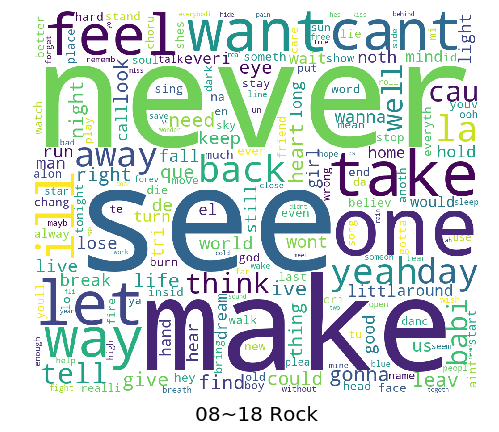

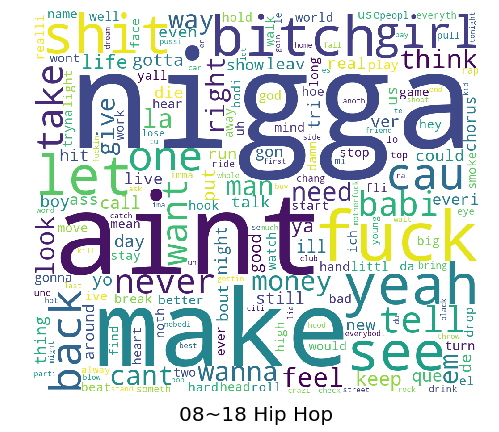

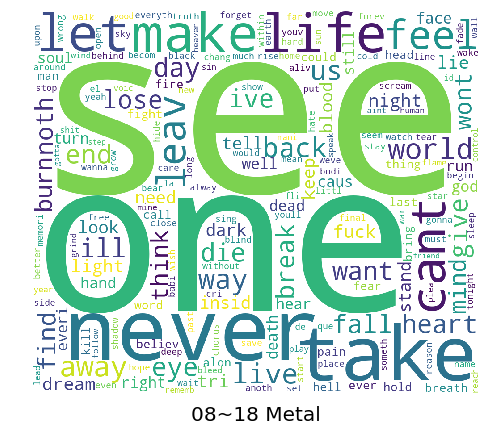

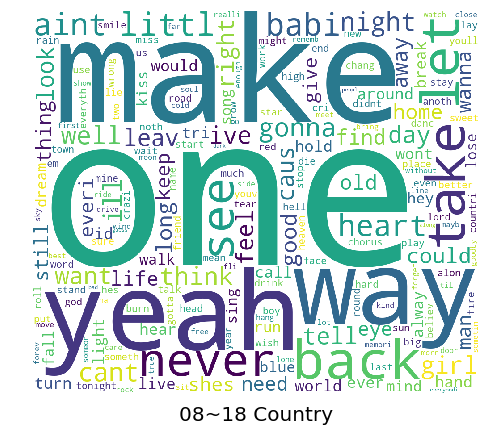

In [41]:
#08~18 rock wordcloud
fig=plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.title('08~18 Rock',fontsize=20,pad=-410)
word_cloud(Xr)

fig=plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.title('08~18 Hip Hop',fontsize=20,pad=-410)
word_cloud(Xh)

fig=plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.title('08~18 Metal',fontsize=20,pad=-410)
word_cloud(Xm)

fig=plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.title('08~18 Country',fontsize=20,pad=-410)
word_cloud(Xc)


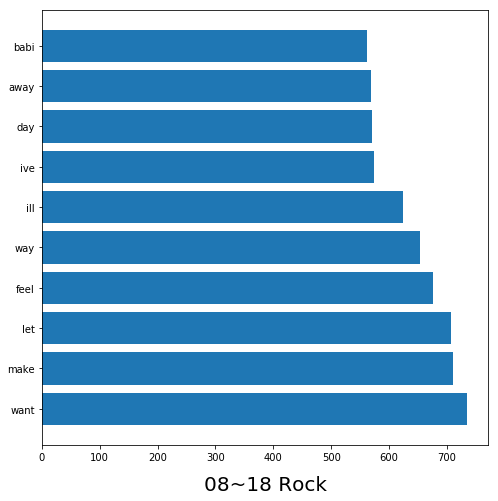

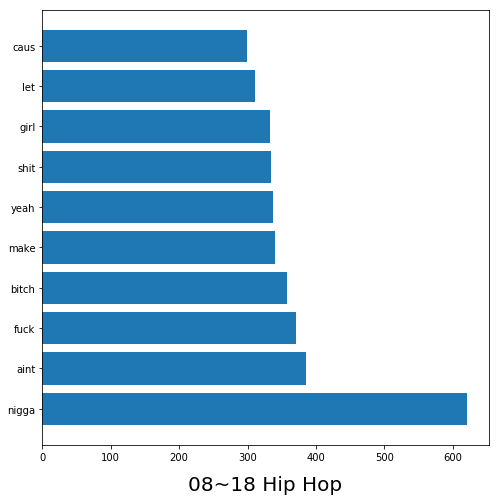

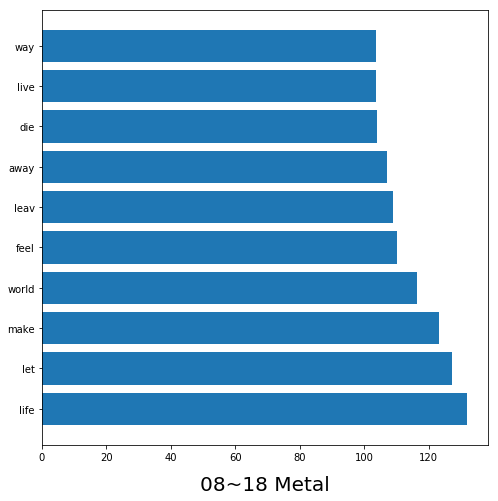

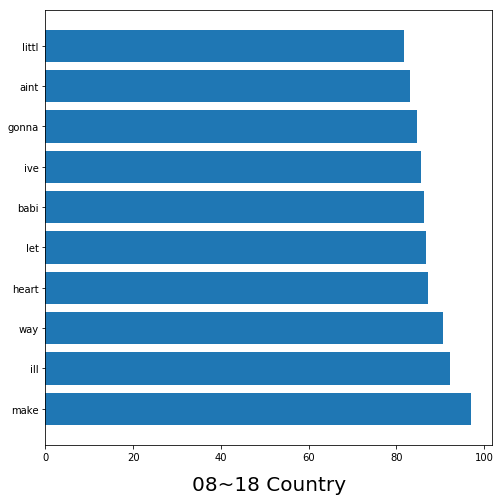

In [42]:
Xv,tfidfv = vectorizer(Xr)
fig=plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.title('08~18 Rock', fontsize=20,pad=-480)
term_rank(Xv,tfidfv)

Xv,tfidfv = vectorizer(Xh)
fig=plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.title('08~18 Hip Hop', fontsize=20,pad=-480)
term_rank(Xv,tfidfv)

Xv,tfidfv = vectorizer(Xm)
fig=plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.title('08~18 Metal', fontsize=20,pad=-480)
term_rank(Xv,tfidfv)

Xv,tfidfv = vectorizer(Xc)
fig=plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.title('08~18 Country', fontsize=20,pad=-480)
term_rank(Xv,tfidfv)

In [44]:
df =prepare_data("C:/Users/jackpork0702/Desktop/lyrics_kaun/lyrics.csv")
df=select_year(df,1998,2008)

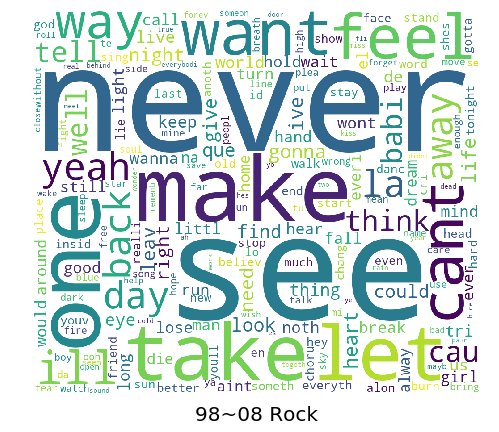

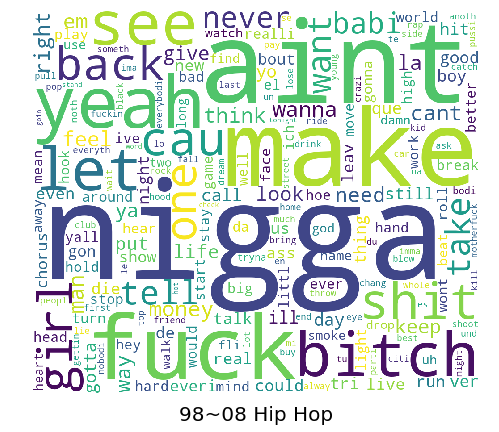

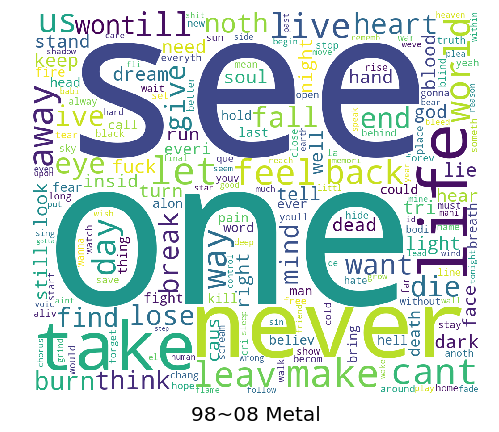

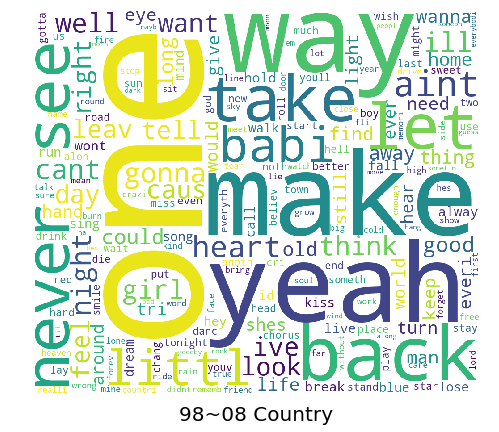

In [45]:
#98~08 wordcloud
fig=plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.title('98~08 Rock', fontsize=20,pad=-410)
word_cloud(Xr)

fig=plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.title('98~08 Hip Hop', fontsize=20,pad=-410)
word_cloud(Xh)

fig=plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.title('98~08 Metal', fontsize=20,pad=-410)
word_cloud(Xm)

fig=plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.title('98~08 Country', fontsize=20,pad=-410)
word_cloud(Xc)

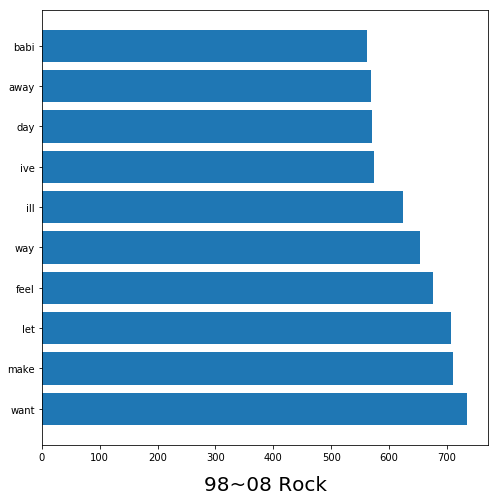

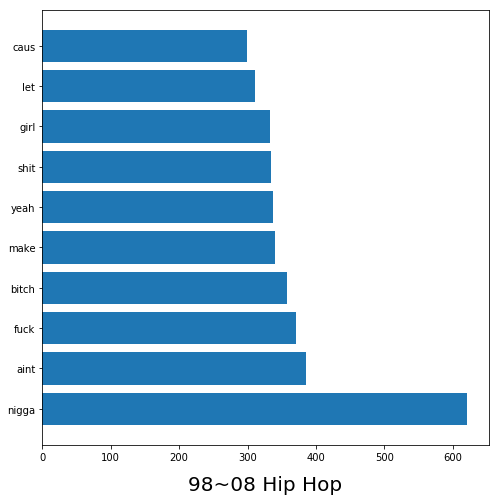

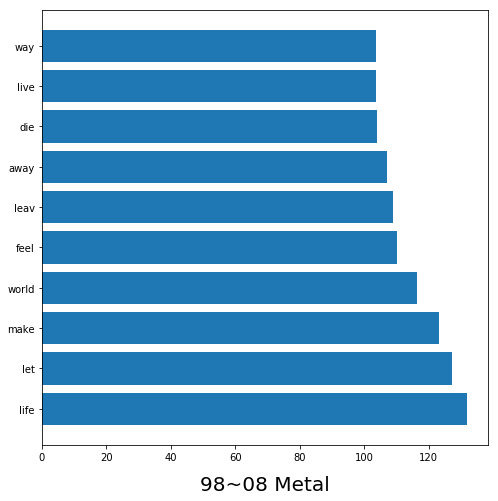

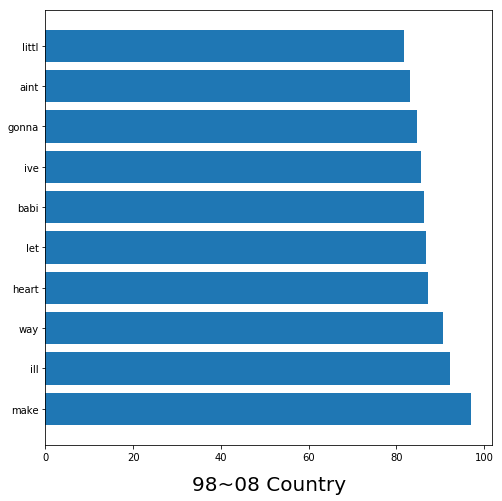

In [46]:
Xv,tfidfv = vectorizer(Xr)
fig=plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.title('98~08 Rock', fontsize=20,pad=-480)
term_rank(Xv,tfidfv)

Xv,tfidfv = vectorizer(Xh)
fig=plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.title('98~08 Hip Hop', fontsize=20,pad=-480)
term_rank(Xv,tfidfv)

Xv,tfidfv = vectorizer(Xm)
fig=plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.title('98~08 Metal', fontsize=20,pad=-480)
term_rank(Xv,tfidfv)

Xv,tfidfv = vectorizer(Xc)
fig=plt.figure()
fig.set_figheight(8)
fig.set_figwidth(8)
plt.title('98~08 Country', fontsize=20,pad=-480)
term_rank(Xv,tfidfv)